## Final Project Submission

Please fill out:
* Student name: Steven Rosa
* Student pace: part time
* Scheduled project review date/time: Tues 27 Nov 2018 5pm
* Instructor name: Jeff Herman
* Blog post URL:


# King County Housing Data Analysis

Using data describing conditions, sizes, locations, &c., of houses in King County, can we build a model to optimize the price of a house?

In [1]:
import pandas as pd             #for working with data as a DataFrame object
import matplotlib.pyplot as plt #for plotting simple visualizations
from scipy import stats
import numpy as np              #for math operations like log
import seaborn as sns           #for plotting advanced visualizations

In [80]:
#for dividing data into a training set and a testing set
from sklearn.model_selection import train_test_split 

#for fitting the model to training and testing data
from sklearn.linear_model import LinearRegression

#for calculating MSE of residuals
#(squares each error to remove cancelling-out effect of negative errors, 
#then finds mean of them all)
from sklearn.metrics import mean_squared_error

#for selecting the most important features in a model
from sklearn.feature_selection import RFE

In [3]:
import random              #for generating random numbers for train/test split

In [4]:
df_raw = pd.read_csv('kc_house_data.csv') #Import data as a Pandas DataFrame

In [5]:
#To read house prices as $ amounts instead of in scientific notation
pd.set_option('display.float_format', '{:.2f}'.format) 

In [6]:
#Function to generate in-line histograms
def inlinehists(xs, data, bins):
    fig, axs = plt.subplots(1, len(xs), sharey=False, figsize=((5 * len(xs), 4)))
    for i, x in enumerate(xs):
        data[x].hist(ax=axs[i], label=x, xlabelsize=5, bins=bins)
        axs[i].legend()
    plt.show()

In [145]:
#Function to use scikitlearn's RFE to select features
def select_features(df, target_col, num_of_feats):
    features = df.drop([target_col], axis=1)
    target = df[target_col]
    X = features
    y = target
    linreg = LinearRegression() #Instantiate a new linreg object
    #Instantiate a selector object to choose features
    selector = RFE(linreg, n_features_to_select = num_of_feats) 
    selector = selector.fit(X, y)
    selector.support_ #Returns an array of bools with selected features "True"
    #Take only those columns from X that were chosen by the selector
    selected_columns = X.columns[selector.support_ ]
    #Fit the selected columns to another model
    linreg.fit(X[selected_columns],y)
    intercept = linreg.intercept_
    r_squared = linreg.score(X[selected_columns], y)
    
    return selector.support_, intercept, r_squared

In [ ]:
#"Get Ys and Y-hats": Function to fit a linear regression model with sklearn
#linreg object. Returns y values and predicted y values from test/train split
#def get_ys_yhats(X, y, size)
    #Use sklearn train_test_split to set aside some data for training
#    X_train, X_test, y_train, y_test = train_test_split(X, y, size=size/100)
    #Fit the training part of the data to the model
#    linreg.fit(X_train, y_train)
    #
#    y_hat_train = linreg.predict(X_train)
#    y_hat_test = linreg.predict(X_test)
    return y_train, y_test, y_hat_train, y_hat_test    

## A first look at the raw data

In [ ]:
df_raw.info()

In [ ]:
df_raw.describe()

**Observations of data summary**

Columns to drop: ID and date (not useful here); lat and long (would be useful, but they're outside the scope of this exploration.)

Categorical columns to transform later: waterfront, view, condition, grade, zip code.

Null values to fill: waterfront, view, yr_renovated.

Price column initially displayed in scientific notation. Suppressed this globally so that prices can be understood as $ amounts.

The max value for bedrooms is preposterous and that row will probably need to be dropped if the rest of the data in the row doesn't describe a 33-bedroom house. Dropping it might also improve the distribution of other columns.

sqft_basement should be in integers to match sqft_above.

**Observations of histograms of each feature**



In [ ]:
df_raw['price'].hist(bins=100, figsize=(8,6))

**price**: Will serve as the target, i.e. 'y', the dependent variable. We'll examine how other features effect the price of a house. A few extreme outliers on the positive side are skewing the data. (Extravagant mansions worth over 3 or 4 million dollars.) Might help to drop them.

In [ ]:
inlinehists(['bedrooms', 'bathrooms'], df_raw, 40)

**bedrooms**: Positively-skewed by a few many-bedroomed houses.

**bathrooms**: Looks not too far from a normal distribution, can probably be smoothed out. Some positive skew.

In [ ]:
inlinehists(['floors', 'condition', 'grade'], df_raw, 20)
inlinehists(['view', 'waterfront'], df_raw, 10)

**floors**: Looks categorical but would remain useful as a numerical feature for its mean, &c. Densely-distributed around the 1-floor and 2-floor values. This makes sense as a house with with fewer than 1 floor wouldn't fit humans.

**condition**: Categorical; not too abnormally-distributed. Makes sense that most houses would be in a medium condition.

**Grade**: Categorical; very normally-distributed. Similar to condition, most houses have a "medium" grade which makes sense. The tails of the distribution will be rundown houses and fancy houses.

**view**: A categorical feature with most houses having a "0" view. Makes sense intuitively that the this data wouldn't be normally distributed: the majority of houses wouldn't have even a "medium"-grade view. They'd have no interesting view at all, just a view of other houses in their neighborhood.

**waterfront**: A categorical feature, "yes" or "no", with the vast majority of houses not being on the waterfront. Makes sense. Might be the case that dropping the extravagant mansion rows will remove most of the "yes" waterfront houses, meaning this column will need to be dropped.

In [ ]:
inlinehists(['sqft_above', 'sqft_living', 'sqft_living15'], df_raw, 40)
inlinehists(['sqft_lot', 'sqft_lot15'], df_raw, 20)

**sqft_above**: Close to a normal distribution wiht some outliers positively skewing the data.

**sqft_living**: Similar shape to sqft_above, outliers positively skewing the data.

**sqft_living15**: Even more normal than sqft_living. Probably contains fewer meaningful values.

**sqft_lot**: A few extreme outliers are positively skewing the data. Might be the same extravagant mansions.

**sqft_lot15**: Similar issue to sqft_lot. A few extreme outliers are positively skewing the data.

In [ ]:
inlinehists(['yr_built', 'yr_renovated'], df_raw, 40)

**yr_built**: Negative skew towards earlier years. A spurt of new construction in the very recent past. Not sure whether to expect a normal distribution of this feature if we assume that the population of the city increases steadily from decade to decade; the bulk of the housing stock would already exist and wouldn't be replaced, but some new residents would move into new construction neighborhoods.

**yr_renovated**: If only describing renovations after 2015, then it's a categorical column.

## Cleaning the raw data

**Resetting the index**

In [7]:
df_raw = df_raw.reset_index(drop=True) #Prevents dropped rows from throwing errors later

**Dropping irrelevant columns**

In [8]:
df_raw = df_raw.drop(['id', 'date', 'lat', 'long'], axis=1) #Drop the id and date columns

**Dropping the 33-bedroom house**

Let's check if there are any other over-bedroomed houses.

In [ ]:
df_raw['bedrooms'].value_counts() #Check for other houses with a lot of bedrooms

The 10- and 11-bedroom houses also look suspicious.

In [ ]:
beds_10 = df_raw[df_raw['bedrooms'] >= 10]  
beds_10

The only house whose specs look plausible is row 13301. (5 bathrooms, price over 1 mil.) Going to drop the others.

In [9]:
df_raw = df_raw.drop([8748, 15147, 15856, 19239]) # Drop the rows with 10-or-more-bed houses

**Dropping the extravagant mansions**

Positive skew in the histogram of the price column suggests that a few extremely-high-value houses could be dropped.

In [ ]:
print('99% of houses have a price under', df_raw['price'].quantile(.99)) #Return 99th percentile

In [ ]:
over2mil = df_raw[df_raw['price'] > 2000000]
over3mil = df_raw[df_raw['price'] > 3000000]
over4mil = df_raw[df_raw['price'] > 4000000]

print('House prices over 2 mil: ', over2mil.shape[0])
print('House prices over 3 mil: ', over3mil.shape[0])
print('House prices over 4 mil: ', over4mil.shape[0])

Let's drop the outliers over 3 million to reduce the positive skew of the price feature.

In [10]:
df_raw = df_raw[df_raw['price'] < 3000000] #Drop rows with price over 3 mil

**Filling in null values for waterfront**

How many null values?

In [ ]:
#Every null value is returned as False; add up the Falses for total of nulls
print(df_raw['waterfront'].isna().sum(), 'null values in waterfront column') 

It's safe to assume these 2376 houses do not front the water. Let's fill them with 0. Later they'll be converted to a categorical value.

In [11]:
df_raw['waterfront'] = df_raw['waterfront'].fillna(0) #Fill null values with 0, i.e. "Is waterfront = False"

**Filling in null values for view**

How many null values are there, and which other value is the most reasonable to fill them with?

In [ ]:
print(df_raw['view'].value_counts()) #Returns the sum of the observations of each value in the column
print('\n')
print('Total nulls in view: ', df_raw['view'].isna().sum())

Most houses have a "0" view. That's a pity. We can assume the 62 nulls also have a "0" view.

In [12]:
df_raw['view'] = df_raw['view'].fillna(0)

**Filling in null values for yr_renovated**

How many rows have a yr_renovated value that isn't 0 or null?

In [ ]:
yr_rn_total = df_raw.shape[0] #Total number of rows in yr_renovated
yr_rn_zeros = df_raw[df_raw['yr_renovated'] == 0.00].shape[0] #Number of 0 values in yr_renovated
yr_rn_nulls = df_raw['yr_renovated'].isna().sum() #Number of nulls in yr_renovated

print('Rows in yr_renovated: ', yr_rn_total)
print('Zero values: ', yr_rn_zeros)
print('Null values: ', yr_rn_nulls)
print('Non-zero, non-null values: ', (yr_rn_total - yr_rn_zeros - yr_rn_nulls))

Not enough values for the column to be useful. Let's drop it.

In [13]:
df_raw = df_raw.drop(['yr_renovated'], axis=1) #Drop the yr_renovated column

**Converting sqft_basement to integers**

In [ ]:
df_raw['sqft_basement'].head(7)

In [ ]:
type(df_raw['sqft_basement'][1]) #Looks like the float 400.0 but is actually the str'400.0'

This column is riddled with '?'s and values that look numerical but are actually strings. Let's replace '?' with 0, and convert the fake number strings into floats, and then into integers.

In [14]:
df_raw['sqft_basement'] = df_raw['sqft_basement'].replace('?', 0)
df_raw['sqft_basement'] = df_raw['sqft_basement'].astype('float') #Must convert strings to floats first
df_raw['sqft_basement'] = df_raw['sqft_basement'].astype('int') #Then convert the floats to integers

## A second look

In [ ]:
#IN PROGRESS

In [ ]:
df_raw['price'].hist(bins=100)

In [ ]:
columns_for_hist = ['bathrooms', 'bedrooms', 'condition', 'floors', 'grade', 'price', 'sqft_above', 'sqft_basement', 'sqft_living', 'sqft_living15']

plt.figure(figsize=(10,10))
plt.scatter(df_raw['bedrooms'], df_raw['price'])
plt.show()

### Checking for multicollinearity

Let's use a heatmap to check if any features follow the same curve as any others. Collinearity could reduce the accuracy of our model later on.

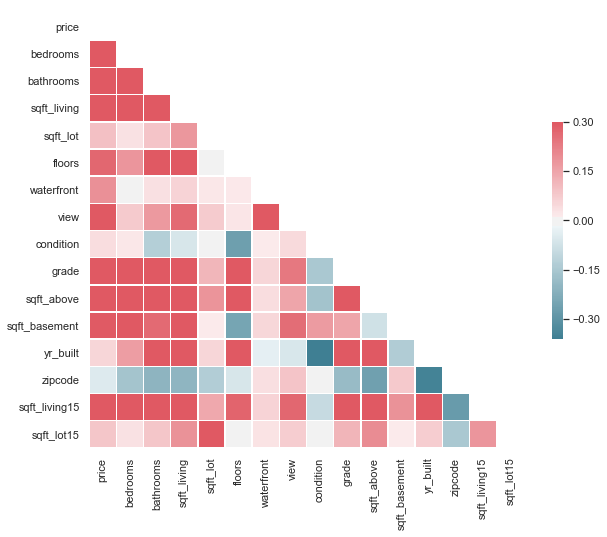

In [15]:
sns.set(style="white")
corr = df_raw.corr() # Create a covariance matrix
mask = np.zeros_like(corr, dtype=np.bool) #a mask the size of the matrix
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(10, 8)) # Set up the matplotlib figure
cmap = sns.diverging_palette(220, 10, as_cmap=True) #custom diverging colormap
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, #Draw the heatmap
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Yikes. There is a lot of collinearity across columns. But we probably don't need 6 different measures of square footage. Let's pick 1 or 2.

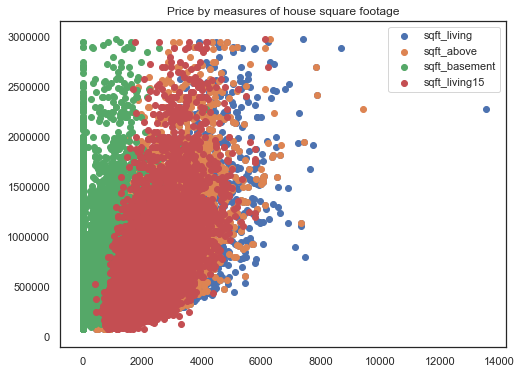

In [16]:
#Plot the first 4 measures of sqft on top of each other to compare
plt.figure(figsize=(8, 6))
plt.scatter(df_raw['sqft_living'], df_raw['price'], label='sqft_living')
plt.scatter(df_raw['sqft_above'], df_raw['price'], label='sqft_above')
plt.scatter(df_raw['sqft_basement'], df_raw['price'], label='sqft_basement')
plt.scatter(df_raw['sqft_living15'], df_raw['price'], label='sqft_living15')
plt.title('Price by measures of house square footage')
plt.legend()

A lot of overlap among all 4. Let's keep sqft_living and drop the rest.

In [ ]:
#Plot the other 2 measures of sqft to compare
plt.figure(figsize=(8, 6))
plt.scatter(df_raw['sqft_lot'], df_raw['price'], label='sqft_lot')
plt.scatter(df_raw['sqft_lot15'], df_raw['price'], label='sqft_lot15')
plt.title('Price by measures of lot square footage')
plt.legend()

Neither of these looks very helpful. Not only do they overlap each other quite closely, but the upward thrust close to x=0 suggests that smaller lots are priced across the full range of price values. In other words, you can probably maximize the value of your house even if your lot is small.

In [17]:
df_raw = df_raw.drop(['sqft_above', 'sqft_basement', 'sqft_living15', 
                      'sqft_lot', 'sqft_lot15'], axis=1) #Drop multicollinear columns
df_raw = df_raw.rename(index=str, columns={'sqft_living': 'sqft'})

## Questions

1. How strong is the relationship between price on the one hand and view and waterfront on the other? These features of a house are outside the control of the homeowner. If the relationship is weak, we may be able to encourage homeowners that they can maximize their house's value with features under their control.

2. Should you improve the condition of your house before you try to sell it, or is it possible to get a high price on a ramshackle house on the merits of its other features, e.g. its location?

3. Do certain zip codes have more high-value houses than others? If so, a good way to increase the value of one's home may be to make civic improvements in the larger neighborhood.

In [ ]:
#sns.pairplot(df_raw, x_vars=[df_raw['view'], df_raw['waterfront']], y_vars=df_raw['price'], kind='reg', height=(10))

## Feature scaling of continuous variables

In [18]:
df_normed = df_raw.copy() # A deep copy of the raw data to normalize

**Box-Cox transformation (TEST)**

In [ ]:
#BoxCox experiment

#plt.hist(df_raw['sqft_living'], bins=50)

In [ ]:
#transform = np.asarray(df_raw[['sqft_living']].values)

In [ ]:
#dft = stats.boxcox(transform)[0]

In [ ]:
#plt.hist(dft, bins=50)
#plt.show()

**Log-transforming of continuous variables**

In [19]:
#First log-transform each column to reduce skew
#and set a similar scale for each
price_normed = np.log(df_normed['price'])
sqft_normed = np.log(df_normed['sqft']) 
yr_built_normed = np.log(df_normed['yr_built'])

**Scaling continuous variables**

In [20]:
#Use min-max scaling to reduce effect of outliers
price_normed = (price_normed - min(price_normed)) / (max(price_normed) - min(price_normed))

#Standardize to take z-scores
sqft_normed = (sqft_normed - sqft_normed.mean()) / sqft_normed.std()
yr_built_normed = (yr_built_normed - yr_built_normed.mean()) / yr_built_normed.std()

In [21]:
#Replace the columns with the normalized data
df_normed['price'] = price_normed
df_normed['sqft'] = sqft_normed
df_normed['yr_built'] = yr_built_normed

## Converting categorical variables

In [22]:
df_cat = df_normed.copy() #Normalized data, ready for categorizing

In [23]:
#Convert data to dtype 'category'
df_cat['waterfront'] = df_cat['waterfront'].astype('bool').astype('category')
df_cat['view'] = df_cat['view'].astype('int').astype('category')
df_cat['condition'] = df_cat['condition'].astype('int').astype('category')
df_cat['grade'] = df_cat['grade'].astype('int').astype('category')
df_cat['zipcode'] = df_cat['zipcode'].astype('category')

In [24]:
#Create a new set of columns for each category
water_dummies = pd.get_dummies(df_cat['waterfront'], prefix='water')
view_dummies = pd.get_dummies(df_cat['view'], prefix='view')
condit_dummies = pd.get_dummies(df_cat['condition'], prefix='condit')
grade_dummies = pd.get_dummies(df_cat['grade'], prefix='grade')
zip_dummies = pd.get_dummies(df_cat['zipcode'], prefix='zip')

In [25]:
#Drop original columns
df_cat = df_cat.drop(['waterfront', 'view', 'condition', 'grade', 'zipcode'], axis=1)
#Add the new columns
df_cat = pd.concat([df_cat, water_dummies, view_dummies, condit_dummies, grade_dummies, zip_dummies], axis=1)
print(f"df_cat now has {df_cat.shape[1]} columns")

df_cat now has 99 columns


Now let's drop the last column of each category. (Values not contained in any other column in the set of dummies will by default by contained in the last column, so we can assume they are there and drop it.)

In [26]:
df_cat = df_cat.drop(['water_True', 'view_4', 
                      'condit_5', 'grade_13', 'zip_98199'], axis=1)
print(f"df_cat now has {df_cat.shape[1]} columns")

df_cat now has 94 columns


## Modeling

In [27]:
df = df_cat.copy() #Final version of data, ready for modeling

What about the number of bedrooms, bathrooms, and floors? Could sqft serve as a proxy for these?

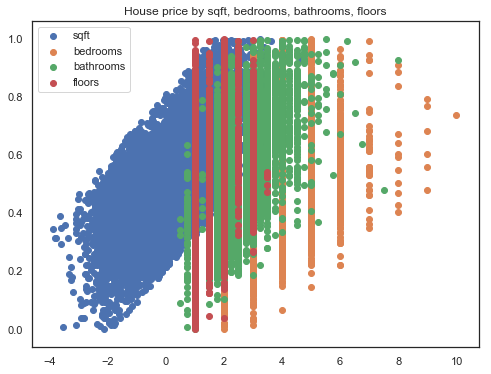

In [28]:
plt.figure(figsize=(8,6))
plt.scatter(df['sqft'], df['price'], label='sqft')
plt.scatter(df['bedrooms'], df['price'], label='bedrooms')
plt.scatter(df['bathrooms'], df['price'], label='bathrooms')
plt.scatter(df['floors'], df['price'], label='floors')
plt.title('House price by sqft, bedrooms, bathrooms, floors')
plt.legend()
plt.show()

Strong collinearity among sqft, bedrooms, and bathrooms. It looks like sqft will have the clearest linear relationship with price, so let's use it in comparisons with the other features. It can be taken as a good proxy for the overall area of a house's rooms and floors.

In [29]:
df = df.drop(['bedrooms', 'bathrooms', 'floors'], axis=1)

In [ ]:
df.head()

C:\Users\Stee\Anaconda3good\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


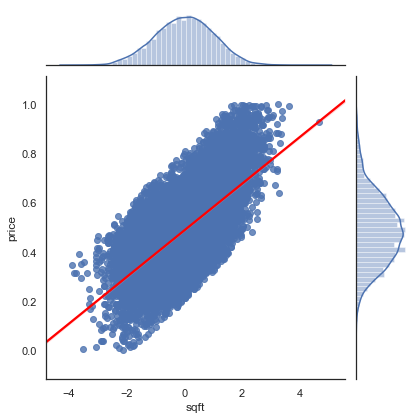

In [30]:
#Sqft has an almost-perfectly linear relationship with price

sns.jointplot(x='sqft', y='price', data=df, kind='reg', 
                  label='sqft', joint_kws={'line_kws':{'color':'red'}})

## The first model

In [31]:
features = df.drop(['price'], axis=1)
target = df['price']
X = features
y = target

In [34]:
#Divide the data in X and y into proportionate sets for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(0.3))

In [35]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

15079 6463 15079 6463


In [36]:
linreg = LinearRegression() #Initialize a model

In [37]:
linreg.fit(X_train, y_train) #Fit the training data to the model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [38]:
#Calculate predicted y (price) values on the training set of x (features)
y_hat_train = linreg.predict(X_train)
#Calculate predicted y (price) values on the testing set of x (features)
y_hat_test = linreg.predict(X_test)

In [39]:
#DELETE IF NOT USED LATER
#Calculate residuals (errors between predicted y values and actual y values)
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [40]:
#Crunch the MSE for training data and testing data
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('MSE for training data:', train_mse)
print('MSE for testing data:', test_mse)
print('Intercept:', linreg.intercept_)
print('R^2 score:', linreg.score(X, y))

MSE for training data: 0.002643351816700441
MSE for testing data: 0.002667298017568668
Intercept: 1.0249881381637422
R^2 score: 0.8685574309937332


First model shows very low errors and a very high R-squared score, indicating the model fits the data very well. Doesn't seem like a probable result for a first model, so I'll try some others. My working theory is that sqft is so perfectly-correlated to price that conceal the relationship between price and the other factors. 

## Iterative feature selection for first model

In [203]:
#keep track of how many times each column is chosen
selected_columns = np.zeros(shape=90) 
intercepts = []
r_squareds = []
#iterate over the full range of features in the df
for i in range(1, (len(df.drop(['price'], axis=1).columns) + 1)):
    selected, intercept, r_squared = select_features(df, 'price', i)
    selected_columns += selected.astype('int') # add these to the total
    intercepts.append(intercept) #add intercept to the total
    r_squareds.append(r_squared) #add r_squared to the total

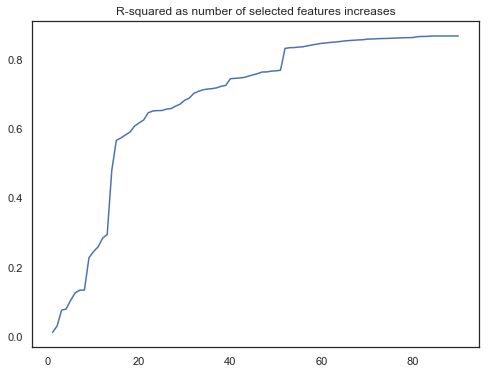

In [224]:
x = pd.DataFrame(list(range(1, (len(r_squareds) + 1))))
y = pd.DataFrame(r_squareds)
fig = plt.figure(figsize = (8,6))
plt.plot(x, y)
plt.title('R-squared as number of selected features increases')
plt.show()

R-squared approaches 0.9 out of 1.0 as number of features increases. Makes dramatic jump starting when zip_98092 is selected along with the first 12 features.

In [227]:
r_squareds[12]

0.2957569284076183

In [232]:
selected, intercept, r_squared = select_features(df, 'price', 12)
print(X.columns[selected])

Index(['water_False', 'grade_3', 'grade_4', 'grade_5', 'grade_6', 'zip_98001',
       'zip_98003', 'zip_98004', 'zip_98023', 'zip_98032', 'zip_98039',
       'zip_98112'],
      dtype='object')


In [229]:
selected, intercept, r_squared = select_features(df, 'price', 13)


[False False  True False False False False False False False False  True
  True  True  True False False False False False False  True False  True
  True False False False False False False False False False  True False
 False False False False False  True False False False  True False False
 False False False False False False False False False False False False
 False  True False False False False False False False  True False False
 False False False False False False False False False False False False
 False False False False False False] 0.7636827302188889 0.2957569284076183


In [231]:
print(X.columns[selected])

Index(['water_False', 'grade_3', 'grade_4', 'grade_5', 'grade_6', 'zip_98001',
       'zip_98003', 'zip_98004', 'zip_98023', 'zip_98032', 'zip_98039',
       'zip_98092', 'zip_98112'],
      dtype='object')


In [184]:
column_totals_unsorted = zip(X.columns, selected_columns)
column_totals = sorted(column_totals_unsorted, key=lambda tup: tup[1], reverse=True)

In [210]:
print('Sqft was selected for', column_totals[51][1], 'out of', len(df.drop(['price'], axis=1).columns), 'models')

Sqft was selected for 38.0 out of 90 models


In [211]:
#column_totals

**Iteratively generating test/train errors to find optimal test-train split**

In [ ]:
#FROM FIRST MODEL

random.seed(9)

training_error = []
testing_error = []
sizes = list(range(5,80,5))
for size in sizes:
    training_error_iter = []
    testing_error_iter = []
    for i in range(80):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(size/100))
        linreg.fit(X_train, y_train)
        y_hat_train = linreg.predict(X_train)
        y_hat_test = linreg.predict(X_test)
        training_error_iter.append(mean_squared_error(y_train, y_hat_train))
        testing_error_iter.append(mean_squared_error(y_test, y_hat_test))
    training_error.append(np.mean(training_error_iter))
    testing_error.append(np.mean(testing_error_iter))
plt.scatter(sizes, training_error, label='Mean training errors')
plt.scatter(sizes, testing_error, label='Mean testing errors')
plt.title('Comparison of mean test/train errors after 80 iterations')
plt.legend()

Why is the MSE always the same for the training data no matter the size?

**Iterative regression**


**ordinary least squares**
use smf.ols
build a formula to put into the function



**recursive feature elimination** 
    Import RFE from sklearn
    make a for loop to run linreg on the data with first 1 feature, then several, then several more, &c. Set up a range with numpy from 1 to the total number of features, going up by 10 or so
    will start to overfit as more features are added
    Compare r square and r square adjusted
    Values will get higher as model gets more accurate (approaching 1 from 0)
    
**train test split**
    Import train test split from sklearn
    Function takes 4 variables
    Perform linreg on the train set and the test set, then compare:
    Calculate MSEs for both train results and test results
    Value will get smaller as model gets more accurate (error gets closer to 0)


**k fold cross validation**
    Pick best features to use by calling RFE
    Call cross_val_score with linreg, X, and y, and choose  a number of folds.
    Returns an array of negative MSEs
    If there are a lot of dummy/categorical variable columns, some MSEs in the resulting array will have weird results. If so, use fewer predictors.
holdout validation

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

docstrings for original functions
map with longitudes/latitudes?
what is "grade" -- look at king county

good summary of linear regression in python at https://towardsdatascience.com/linear-regression-in-python-9a1f5f000606

In [ ]:
Saving this in case it comes up again:
    df_raw.loc[0, 'sqft_basement'] = 0 #Correct way to insert a value into a df without chain indexing